In [1037]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [1038]:
# read grayscale
original = cv2.imread("pic.jpg", cv2.IMREAD_GRAYSCALE)
# original = cv2.imread("mirror.jpg", cv2.IMREAD_GRAYSCALE)
# original = cv2.imread("board.png", cv2.IMREAD_GRAYSCALE)
# original = cv2.imread("respawn.png", cv2.IMREAD_GRAYSCALE)
# original = cv2.imread("board-light.png", cv2.IMREAD_GRAYSCALE)
# original = cv2.imread("example.jpeg", cv2.IMREAD_GRAYSCALE)

In [1039]:
# rescale and blur
img = cv2.resize(original, (750, 750), interpolation=cv2.INTER_AREA)
# img = cv2.GaussianBlur(img, (5, 5), 0)

In [1040]:
def erode(img, size):
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * size + 1, 2 * size + 1), (size, size)
    )

    return cv2.erode(img, element)


def dilate(img, size):
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * size + 1, 2 * size + 1), (size, size)
    )

    return cv2.dilate(img, element)


def opening(x, size=3):
    return dilate(erode(x, size), size)


def closing(x, size=3):
    return erode(dilate(x, size), size)


def sobelY(img):
    return cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

def sobelX(img):
    return cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

def toAbs(img):
    abs_img = np.absolute(img)
    return np.uint8(abs_img)
    

In [1041]:
img = opening(img, 3)
img = closing(img, 5)
# img = cv2.medianBlur(img, 5)
sobY = sobelY(img)
sobX = sobelX(img)

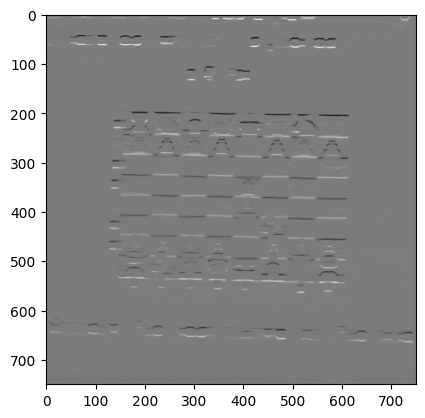

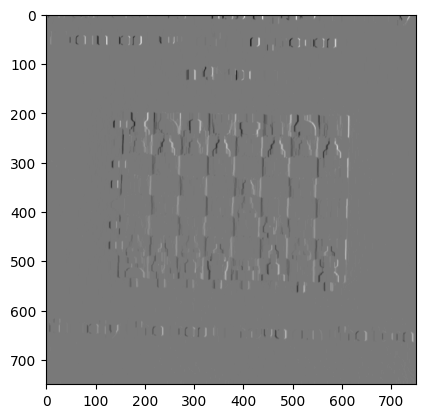

In [1042]:
plt.figure()
plt.imshow(sobX, cmap="gray")
plt.figure()
plt.imshow(sobY, cmap="gray")

In [1043]:
# Convert to binary
_, sobXBinary = cv2.threshold(toAbs(sobX), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, sobYBinary = cv2.threshold(toAbs(sobY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#  Standard Hough Line Transform
linesHorizontal = cv2.HoughLines(sobXBinary, 1, np.pi / 180, 150, None, 0, 0)
linesVertical = cv2.HoughLines(sobYBinary, 1, np.pi / 180, 150, None, 0, 0)

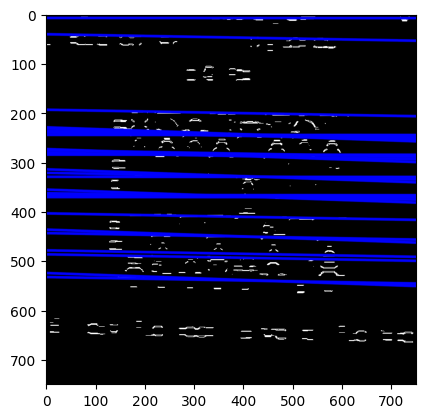

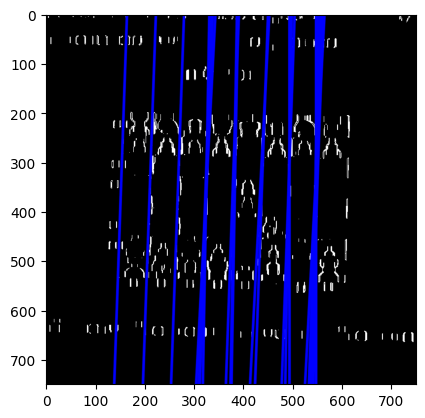

In [1044]:
# Color for showing lines
cdstX = cv2.cvtColor(sobXBinary, cv2.COLOR_GRAY2BGR)
cdstY = cv2.cvtColor(sobYBinary, cv2.COLOR_GRAY2BGR)

if linesHorizontal is not None:
    for i in range(0, len(linesHorizontal)):
        rho = linesHorizontal[i][0][0]
        theta = linesHorizontal[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(cdstX, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

if linesVertical is not None:
    for i in range(0, len(linesVertical)):
        rho = linesVertical[i][0][0]
        theta = linesVertical[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(cdstY, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
# Show results
plt.figure()
plt.imshow(cdstX)
plt.figure()
plt.imshow(cdstY)

Find the average rotation

In [1045]:
angle_threshold = 0.1
sum = 0
count = 0
if linesHorizontal is not None:
    for line in linesHorizontal:
        angle = line[0][1]
        angle -= math.pi/2
        # filter angles within threshold
        if angle > angle_threshold/2 or angle <  - angle_threshold/2:
            continue
        sum += angle
        count += 1

if linesVertical is not None:
    for line in linesVertical:
        angle = line[0][1]
        if angle > math.pi/2:
            angle -= math.pi
        # filter angles within threshold
        if angle > angle_threshold/2 or angle <  - angle_threshold/2:
            continue
        sum += angle
        count += 1
    
    
avg_rotation = sum/count
print(avg_rotation)

0.020556085458194793


Rotate Sobel X and Y

In [1046]:
def rotate(img, angle):
    rows,cols = img.shape
    # cols-1 and rows-1 are the coordinate limits.
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

sobX = rotate(sobX,avg_rotation * 180 / math.pi)
sobY = rotate(sobY,avg_rotation * 180 / math.pi)

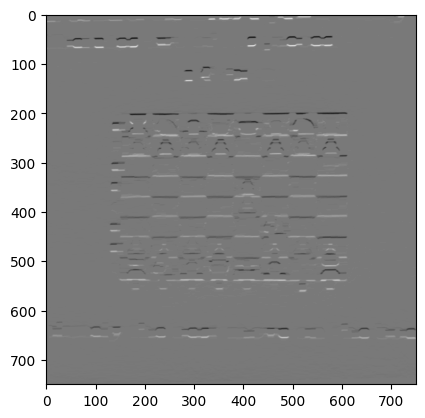

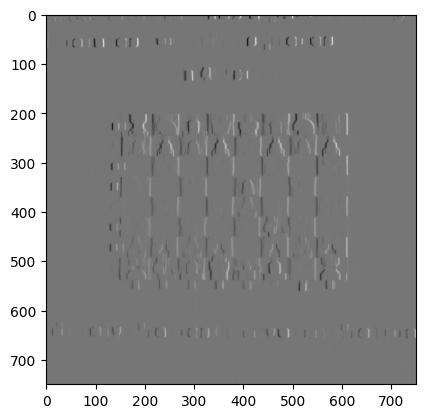

In [1047]:
plt.figure()
plt.imshow(sobX, cmap="gray")
plt.figure()
plt.imshow(sobY, cmap="gray")

In [1048]:
dx_pos = np.clip(sobX, 0, 255)
# dx_pos = dilate(dx_pos, 1)
dx_neg = np.clip(sobX, -255, 0)
dy_pos = np.clip(sobY, 0, 255)
# dy_pos = dilate(dy_pos, 1)
dy_neg = np.clip(sobY, -255, 0)

In [1049]:
dx_pos_sum = np.sum(dx_pos, axis=1)
dx_pos_sum = np.clip(dx_pos_sum, 0 ,np.max(dx_pos_sum) / 3)
dx_neg_sum = np.sum(-dx_neg, axis=1)
dx_neg_sum = np.clip(dx_neg_sum, 0 ,np.max(dx_neg_sum) / 3)

dy_pos_sum = np.sum(dy_pos, axis=0)
dy_pos_sum = np.clip(dy_pos_sum, 0 ,np.max(dy_pos_sum) / 3)
dy_neg_sum = np.sum(-dy_neg, axis=0)
dy_neg_sum = np.clip(dy_neg_sum, 0 ,np.max(dy_neg_sum) / 3)

In [1050]:
hough_dx = dx_pos_sum * dx_neg_sum
hough_dy = dy_pos_sum * dy_neg_sum

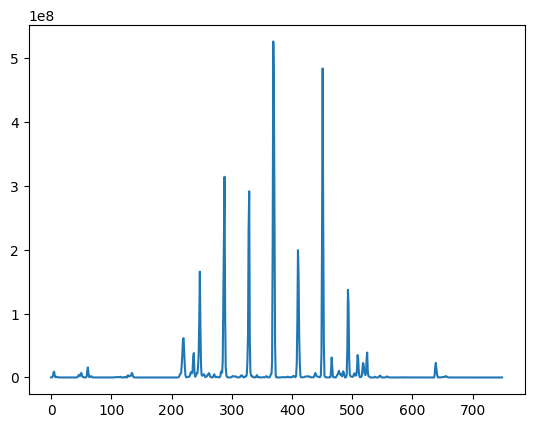

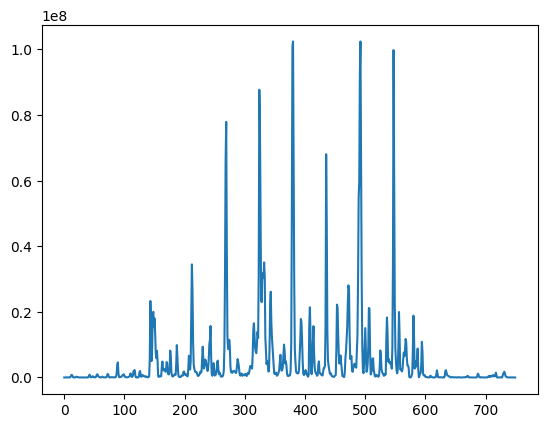

In [1051]:
plt.figure()
plt.plot(hough_dx)
# plt.figure()
# plt.plot(dy_pos_sum)
# plt.plot(dy_neg_sum)
plt.figure()
plt.plot(hough_dy)

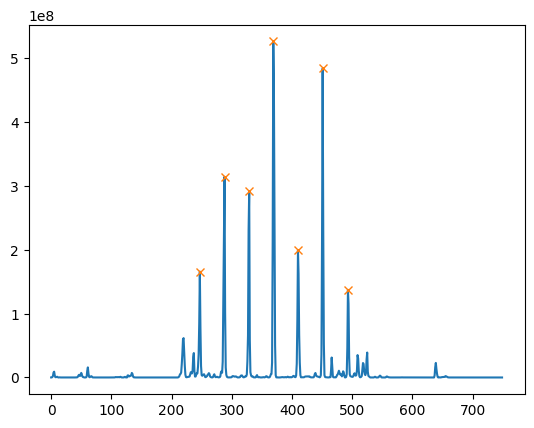

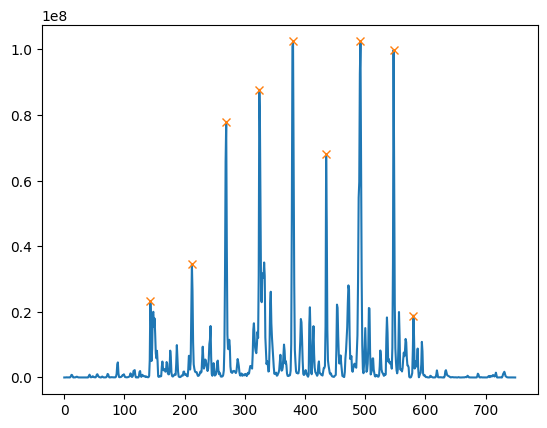

In [1055]:
from scipy.signal import find_peaks
dx_peaks, properties = find_peaks(hough_dx, distance=30, height=np.max(hough_dx) / 10)
plt.plot(hough_dx)
plt.plot(dx_peaks, hough_dx[dx_peaks],"x")
plt.show()

plt.figure()
dy_peaks, _ = find_peaks(hough_dy, distance=30, height=np.max(hough_dy) / 10)
plt.plot(hough_dy)
plt.plot(dy_peaks, hough_dy[dy_peaks],"x")
plt.show()


In [1053]:

# phase = cv2.phase(sobX, sobY)
# # sobX = closing(sobX, 3)
# # multiplied = cv2.multiply(sobX, sobY)

# plt.imshow(phase, cmap="gray")
# # plt.waitforbuttonpress()
# # exit()

# grapharr = phase

# fig, ax = plt.subplots()
# plt.subplots_adjust(bottom=0.25)
# y = 50
# (line,) = plt.plot(grapharr[y])
# plt.grid(True)


# def update(val):
#     y = int(val)
#     line.set_ydata(grapharr[y])
#     fig.canvas.draw_idle()


# from matplotlib.widgets import Slider

# ax_index = plt.axes([0.25, 0.1, 0.65, 0.03])
# slider_index = Slider(ax_index, "Y", 0, len(grapharr) - 1, valinit=y, valstep=1)
# slider_index.on_changed(update)

# plt.show()

In [1054]:
# # Split the image into tiles
# w, h = image.shape
# tiles = []

# for x in range(8):
#     for y in range(8):
#         x1 = round(w * (x/8))
#         x2 = round(w * ((x + 1)/8))
#         y1 = round(h * (y/8))
#         y2 = round(h * ((y + 1)/8))
#         tiles.append(image[x1:x2,y1:y2])


# for tile in tiles:
#     cv.imshow('Block', tile)
#     cv.waitKey(0)
# cv.destroyAllWindows()